In [16]:
import cvxopt
import matplotlib.pyplot as plt
import numpy as np

In [17]:
N = 100
x = np.random.uniform(0, 1, (N, 2))

In [18]:
d = []
C_1 = []
C_min_1 = []
for i in range(N):
    if x[i][1] < (0.2 * np.sin(10*x[i][0])) + 0.3:
        d.append(1)
        C_1.append(x[i])
    elif (x[i][1] - 0.8)**2 + (x[i][0] - 0.5)**2 < 0.15**2:
        d.append(1)
        C_1.append(x[i])
    else:
        d.append(-1)
        C_min_1.append(x[i])

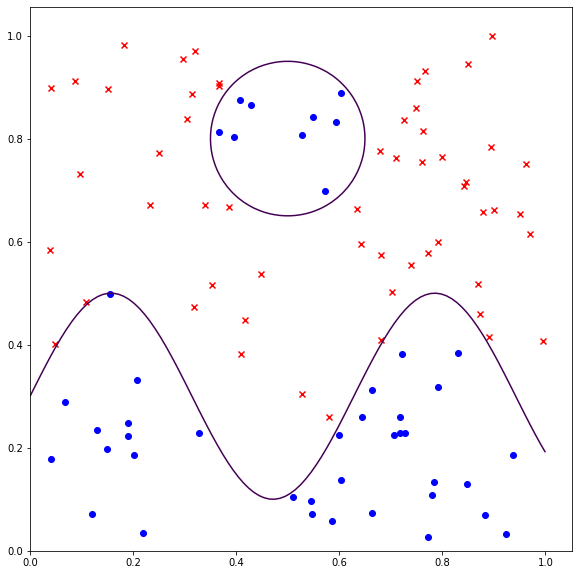

In [19]:
X = np.linspace(-0.0, 1.0, 100)
Y = np.linspace(-0.0, 1.0, 100)

X1, Y1 = np.meshgrid(X, Y)
F1 = (X1 - 0.5)**2 + (Y1 - 0.8)**2 - 0.15**2 
F2 = (-0.2 * np.sin(10* X1)) - 0.3 + Y1
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(*zip(*C_1), c='b', marker='o')
plt.scatter(*zip(*C_min_1), c='r', marker='x')
C1 = plt.contour(X,Y,F1,[0])
C2 = plt.contour(X,Y,F2,[0])
plt.gca().set_aspect('equal')
plt.show()

In [20]:
def linear_kernel(x_, y_):
    return np.dot(x_, y_)

def polynomial_kernel(x_, y_, degree=5):
    return (1 + np.dot(x_, y_)) ** degree

def gaussian_kernel(x_,y_,c):
    return np.exp(-np.linalg.norm(x_ - y_)**2 / (c**2) )

def discriminant(kernel ,X_, alpha, theta, **kwargs):
    # 1, -1 : Support vectors
    # 0 Margin
    # other values 
    val = 0
    if kernel ==0:
        for i in range(N):
          val += alpha[i] * d_arr[i] * linear_kernel(x[i], X_)
    if kernel ==1:
        deg = kwargs['degree']
        for i in range(N):
          val += alpha[i] * d_arr[i] * polynomial_kernel(x[i], X_, deg)
    if kernel ==2:
        for i in range(N):
            sig = kwargs['sigma']
            val += alpha[i] * d_arr[i] * polynomial_kernel(x[i], X_, sig)
    return val + theta 

d_arr = np.array(d).reshape(-1, 1) * 1.

In [21]:
def svm(kernel, **kwargs):
    """
    Kernel can be:
    0 - Linear
    1 - Polynomial
    2 - Gaussian
    """
    if not 0 <= kernel <= 2:
        print("0 - linear\n1 - poly,\n2 - Gaussian\nExiting")
        pass
    if kernel == 0:
        print("Linear Kernel")
        K = np.zeros((N,N))
        for i in range(N):
            for j in range(N):
                K[i,j] = linear_kernel(x[i], x[j])     
    elif kernel == 1:
        print("Polynomial Kernel")
        try:
            deg = kwargs['deg']
        except KeyError:
            #If no degree is specified
            deg = 5
        K = np.zeros((N,N))
        for i in range(N):
            for j in range(N):
                K[i,j] = polynomial_kernel(x[i], x[j], deg)
    elif kernel == 2:
        print("RBF Kernel")
        try:
            sig = kwargs['sig']
        except KeyError:
            sig = 10
        K = np.zeros((N,N))
        for i in range(N):
            for j in range(N):
                K[i,j] = gaussian_kernel(x[i], x[j], sig)
    
    
    P = cvxopt.matrix(np.multiply(np.dot(d_arr, d_arr.T), K))
    q = cvxopt.matrix(np.ones(N) * -1.)
    A = cvxopt.matrix(d_arr, (1, N))
    b = cvxopt.matrix(0.0)
    G = cvxopt.matrix(np.diag(np.ones(N) * -1))
    h = cvxopt.matrix(np.zeros(N))
    
    cvxopt.solvers.options['show_progress'] = False
    sol = cvxopt.solvers.qp(P,q,G,h,A,b)
    alpha = np.ravel(sol['x'])

    #SVs are non 0 
    SV = alpha > 1e-5

    indices = np.arange(len(alpha))[SV]
    # theta = d_s - sigma(alpha_i *d_i* K(x_i, X_s)
    # choose a support vector as all SVs get same value
    k = indices[1]
    theta = np.copy(d_arr[k])
    for i in range(N):
        theta -= alpha[i] * d_arr[i] * K[k,i]
        
    #print("Theta Value = ",theta)

    classified_pos =[]
    classified_neg = []

    #Classify Points based on the theta obtained
    for index in range(N):
        if kernel==0:
            classify = discriminant(kernel, x[index] , alpha, theta)
        elif kernel==1:
            classify = discriminant(kernel, x[index] , alpha, theta, degree=deg)
        elif kernel==2:
            classify = discriminant(kernel, x[index],  alpha, theta, sigma=sig)
        
        
        if classify <= 0.:
            classified_neg.append(x[index])
        elif classify > 0. :
            classified_pos.append(x[index])

    #Print Results
    print("Original H+", len(C_1))
    print("Original H-", len(C_min_1))
    print("H+", len(classified_pos))
    print("H-", len(classified_neg))

    #Get Discriminant (Hyperplane)
    if kernel==0:
        F3 = discriminant(kernel, np.asarray([X1.ravel(), Y1.ravel()]), alpha, theta)
    elif kernel==1:
        F3 = discriminant(kernel, np.asarray([X1.ravel(), Y1.ravel()]), alpha, theta, degree=deg)
    elif kernel==2:
        F3 = discriminant(kernel, np.asarray([X1.ravel(), Y1.ravel()]), alpha, theta, sigma=sig)
    
    #Hyperplane    
    F3 = F3.reshape(F1.shape)
    #H+
    F4 = F3 + 1
    #H-
    F5 = F3 - 1
    fig, ax = plt.subplots(figsize=(15,15))
    #plot points classified
    plt.scatter(*zip(*classified_pos), c='b', marker='o', label='Class 1')
    plt.scatter(*zip(*classified_neg), c='r', marker='x', label='Class -1')
    
    #Contour Plot of the seperators
    Cont_1 = plt.contour(X,Y,F3, [0], colors='black')
    Cont_2 = plt.contour(X,Y,F4, [0], colors='red')
    Cont_3 = plt.contour(X,Y,F5, [0], colors='blue')
    
    #Labelling
    ax.clabel(Cont_1, [0], inline=True, fmt="H")
    ax.clabel(Cont_2, [0], inline=True, fmt="H-")
    ax.clabel(Cont_3, [0], inline=True, fmt="H+")
    plt.legend(loc='best')
    plt.gca().set_aspect('equal')
    plt.show()

Polynomial Kernel
Original H+ 44
Original H- 56
H+ 44
H- 56


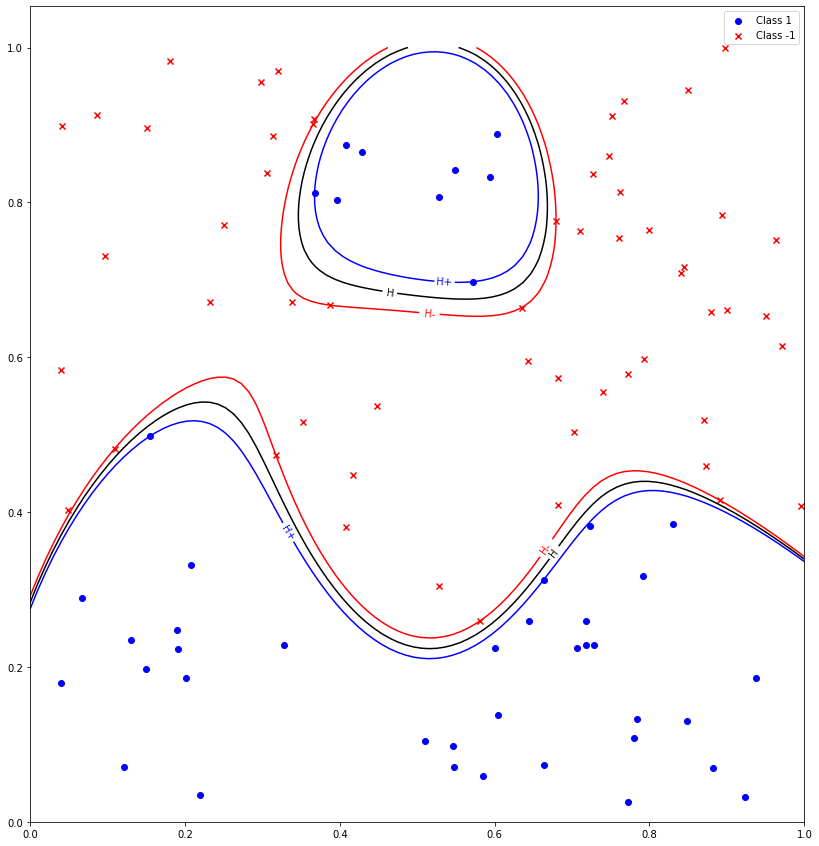

In [22]:
svm(1, deg=4)

Polynomial Kernel
Original H+ 44
Original H- 56
H+ 44
H- 56


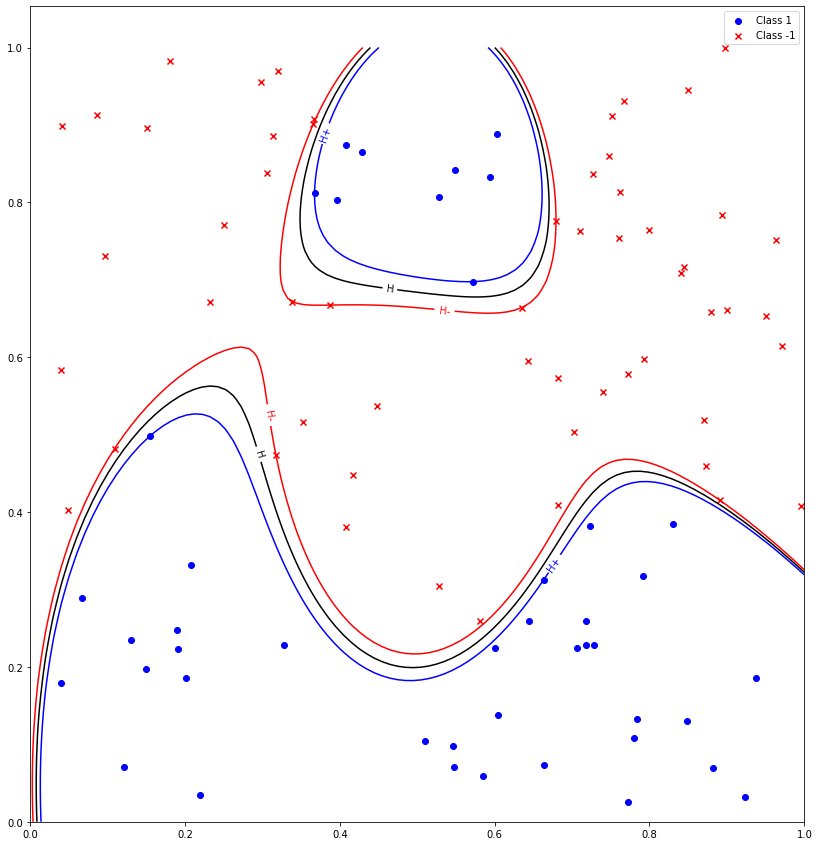

In [23]:
svm(1, deg=6)

Polynomial Kernel
Original H+ 44
Original H- 56
H+ 44
H- 56


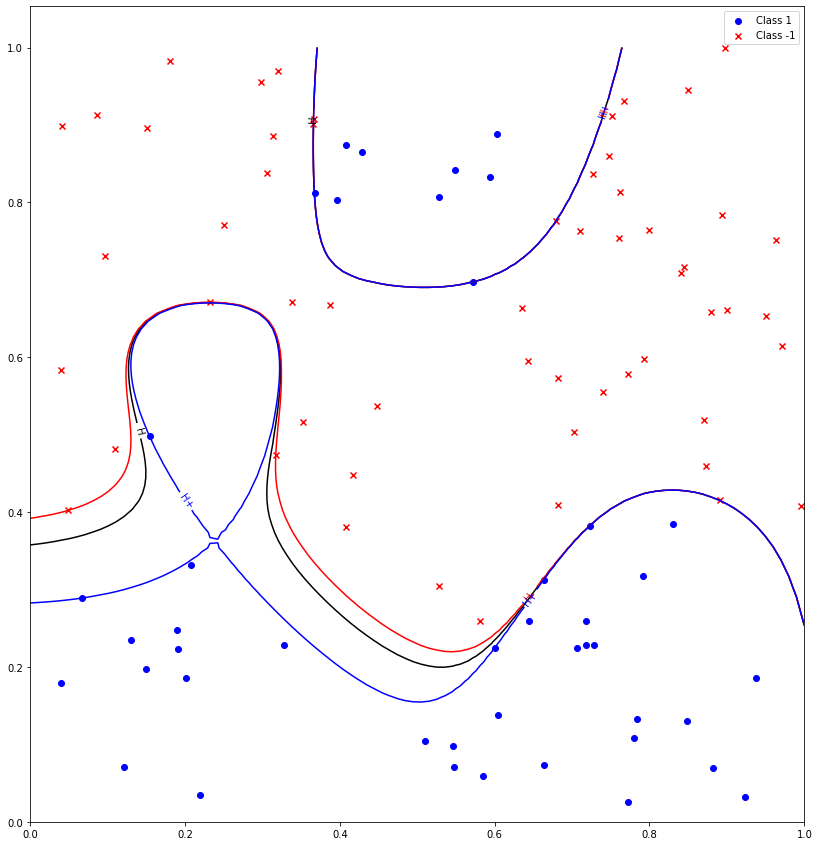

In [24]:
svm(1, deg=50)


